# Graham Scan

## 概要

仕事で平面の点群の凸包を計算する必要があった。いくつかのアルゴリズムが見つかるが、Graham Scanを実装したので内容をメモしておく。

## アルゴリズム

以下では、次のような点群の凸包をGraham Scanのアルゴリズムに従って、実際に計算してみる

In [73]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
_ps = np.array([
    [1,1],
    [-1,1],
    [-1,-1],
    [1,-1],
    [0,0.5],
    [-0.5,0],
    [0,-0.5],
    [0.5,0]
])
def _rotate(theta, ps):
    mat = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])
    return np.dot(ps, mat)
ps = _rotate(10 * np.pi / 180, _ps)

In [75]:
ps

array([[ 0.81115958,  1.15845593],
       [-1.15845593,  0.81115958],
       [-0.81115958, -1.15845593],
       [ 1.15845593, -0.81115958],
       [-0.08682409,  0.49240388],
       [-0.49240388, -0.08682409],
       [ 0.08682409, -0.49240388],
       [ 0.49240388,  0.08682409]])

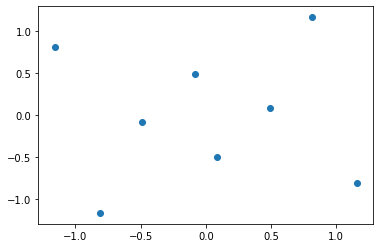

In [76]:
plt.scatter(ps[:,0], ps[:,1])

In [77]:
def _center(ps):
    return np.mean(ps, axis=0)

In [78]:
def _normalize(ps):
    return (ps.T / np.linalg.norm(ps, axis=1)).T

In [79]:
def _angle(p):
    p2 = _normalize(p)
    ac = np.arccos(p2[:,0])
    ac[np.where(p2[:,1] < 0)] *= -1
    ac[np.where(p2[:,1] < 0)] += 2*np.pi
    return ac

In [80]:
def _on_left(a, b, c):
    """
    Parameters
    ----------
    a, b, c: np.ndarray of shape (1, 2).
    
    Returns
    -------
    ret: bool.
    Standing on point a, watching point b, if c is left of the line ab, returned value is True.
    """
    mat = np.ones((3,3))
    mat[:,:2] = [a,b,c]
    return np.linalg.det(mat) > 0

In [81]:
def graham_scan(ps):
    """
    Parameters
    ----------
    ps: np.ndarray of shape (n, 2)
    
    Returns
    -------
    convex hull: np.ndarray of shape (m, 2), where m <= n.
    """
    center = _center(ps)
    ps2 = ps - center
    angle = _angle(ps2)
    ps3 = ps[np.argsort(angle)]
    if len(ps) <= 3:
        return ps3
    start = 0
    p0 = ps3[0]
    n = len(ps)
    for i in range(1, n):
        cur = ps3[i]
        if (cur[0] < p0[0]) or \
            (cur[0] == p0[0] and cur[1] < p0[1]):
            p0 = cur
            start = i
    ps4 = np.vstack([ps3[start:], ps3[:start], [ps3[start]]])
    ret = []
    ret.append(ps4[0])
    ret.append(ps4[1])
    for p in ps4[2:]:
        ret.append(p)
        while len(ret) >= 3 and not _on_left(ret[-3], ret[-2], ret[-1]):
            ret = ret[:-2] + ret[-1:]
    return np.array(ret[:-1])

In [83]:
graham_scan(ps)

array([[-1.15845593,  0.81115958],
       [-0.81115958, -1.15845593],
       [ 1.15845593, -0.81115958],
       [ 0.81115958,  1.15845593]])

In [113]:
ps3 = np.random.normal(0, 1, 100).reshape((-1,2))
gs = graham_scan(ps3)
gs

array([[-1.79835811, -0.31259372],
       [-1.31147364, -2.80773766],
       [-0.43549368, -2.61817401],
       [ 1.57793675, -0.73846837],
       [ 1.75448837, -0.08309306],
       [ 2.22966579,  3.07669342],
       [-1.12215051,  2.1916313 ],
       [-1.51469693,  1.17177124]])

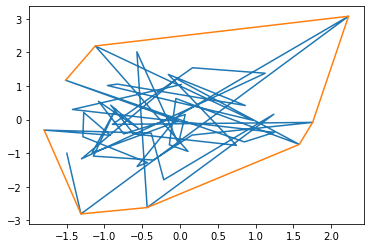

In [114]:
plt.plot(ps3[:,0], ps3[:,1])
plt.plot(gs[:,0], gs[:,1])